In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr
import sys
sys.path.insert(0, '../../src')
import utils.visualization as vis
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list


In [2]:
save_figures = True

folder_name = 'Smartvote'
data_name = 'Binary'
suffix = 'candidates'

methods = ['RandomOrder', 
           'FullKNN',
           'BaseKNN',
           'FixedGini', 
           'DefaultOrder',
           'Uncertainty', 
           'PosteriorRMSE', 
           'PosteriorVariance',
           'RapidVersion'
        ]

metrics = ['Accuracy', 'RMSE']
models  = ['IDEAL']

## Compute Pivots and Rankings

In [3]:
pivots = {}
ranks = {}

for method in methods:
    result = pd.read_csv(f'../../results/ALVAA/{folder_name}_{data_name}_IDEAL_{method}_{suffix}.csv', index_col=0)
    result['Counter'] = result.groupby('User').cumcount()
    pivots[method] = result.pivot(index='User', columns='Counter', values='Question')
    ranks[method] = pivots[method].apply(lambda row: row.sort_values().index, axis=1, result_type='expand')

In [4]:
pivots['Uncertainty'].head()

Counter  0   1   2   3   4   5   6   7   8   9   ...  65  66  67  68  69  70  \
User                                             ...                           
5         7  64  71  28  17  35  10  15  59  63  ...  25  29  44  65   8  23   
9         7  64  71  56  62  18  73  29  42  20  ...  47  59  44   5  22  23   
12        7  73  13  57  21   3  55   6  65   0  ...   8   2  27  45  25  26   
16        7  64  71  56  62  18  42  70  74  13  ...  35  36  24  22  67  19   
26        7  64  54  17  59  63  28  61  41  15  ...  25  29  23  44   8   5   

Counter  71  72  73  74  
User                     
5        53  43   5  45  
9        37  40  55  63  
12       43  44  23   5  
16       58  59  55  63  
26       65  53  43  45  

[5 rows x 75 columns]

In [5]:
ranks['Uncertainty'].head()

0   1   2   3   4   5   6   7   8   9   ...  65  66  67  68  69  70  71  \
User                                          ...                               
5     12  46  48  50  36  73  45   0  69  61  ...  68  54  34  62  21  40   2   
9     37  49  48  45  55  68  30   0  34  53  ...  26  41  60  39  51  14   2   
12     9  53  66   5  47  74   7   0  65  37  ...   8  62  16  64  41  42  49   
16    52  33  25  49  47  31  50   0  29  58  ...  45  42  69  41  43   7   2   
26    12  45  43  52  30  70  50   0  69  63  ...  71  48  40  61  18  34  27   

      72  73  74  
User              
5     60  32  25  
9     11   6  18  
12    61   1  63  
16    23  22   8  
26    57  31  17  

[5 rows x 75 columns]

## Question Counts

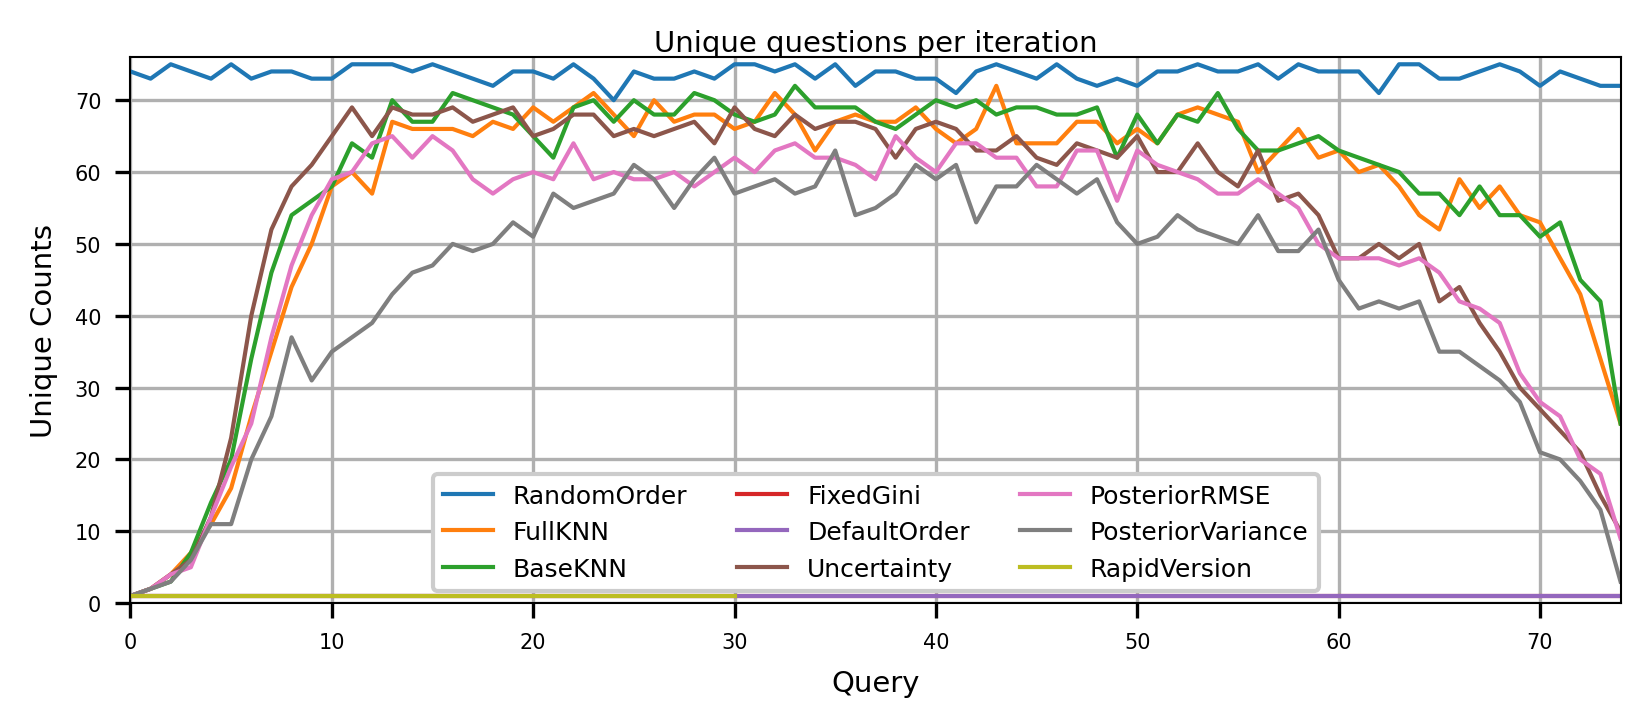

In [6]:
fig, ax = plt.subplots(figsize=(vis.beamerwidth,vis.beamerheight))
for i, method in enumerate(pivots.keys()):
    counts = pivots[method].nunique()
    ax.plot(counts.index, counts.values, color=f'C{i}', label=method, lw=1)
ax.set(ylim=(0,pivots['RandomOrder'].shape[1]+1),
       xlim=(0,pivots['RandomOrder'].shape[1]-1),
       xlabel='Query',
       ylabel='Unique Counts',
    title=f"Unique questions per iteration")
ax.grid()
ax.legend(ncol=3,facecolor='white', framealpha=1)
fig.tight_layout()
vis.savefig(fig, save_figures, 'ecml-paper', folder_name, data_name, name=f'AdaptivityLine')


## Spearman's Rank Correlation

In [8]:
def showAdaptivity(method):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    R = spearmanr(ranks[method], axis=1)    
    h1 = ax1.imshow(R.statistic, cmap='coolwarm', vmin=-1, vmax=1)
    ax1.set_title("Spearman's Rank Correlation")
    plt.colorbar(h1)
    h2 = ax2.imshow(R.pvalue, vmin=0, vmax=1)
    ax2.set_title("P-Values")
    plt.colorbar(h2)
    fig.suptitle(method)
    return fig

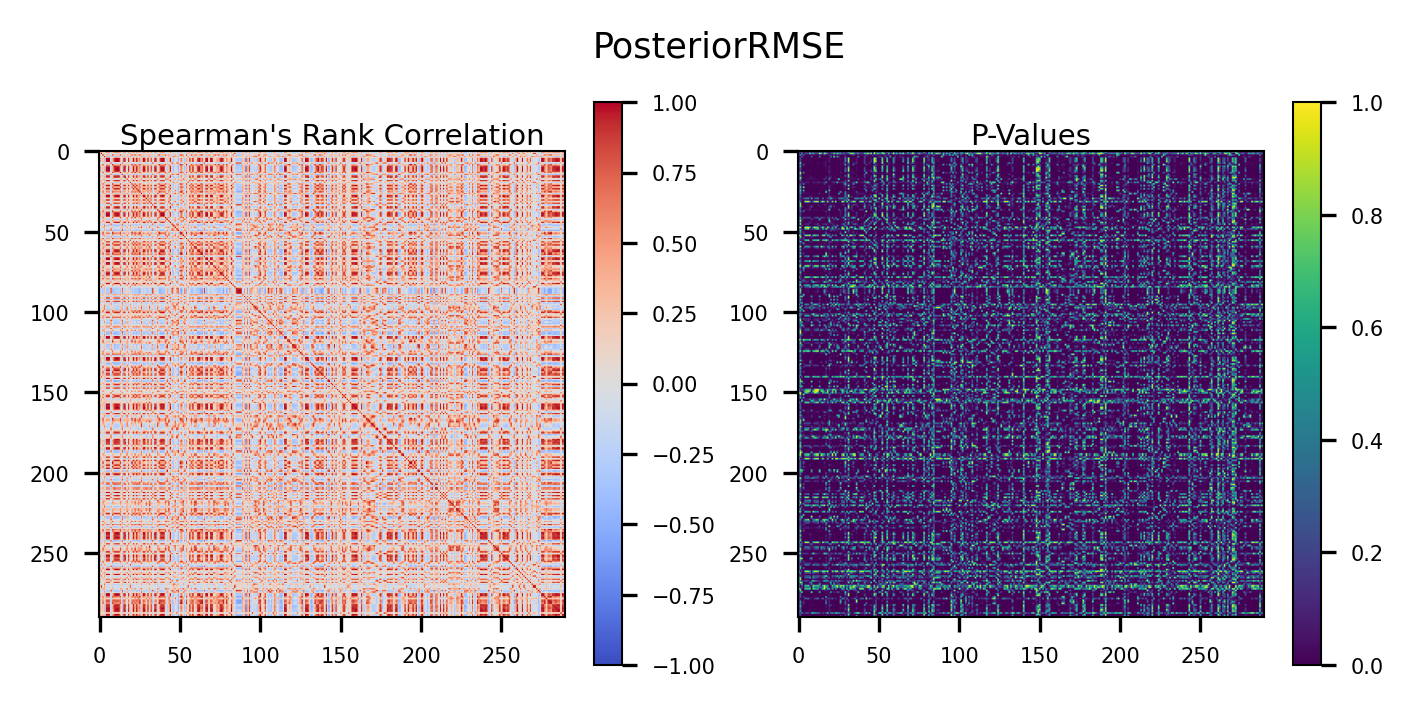

In [9]:
fig = showAdaptivity('PosteriorRMSE')

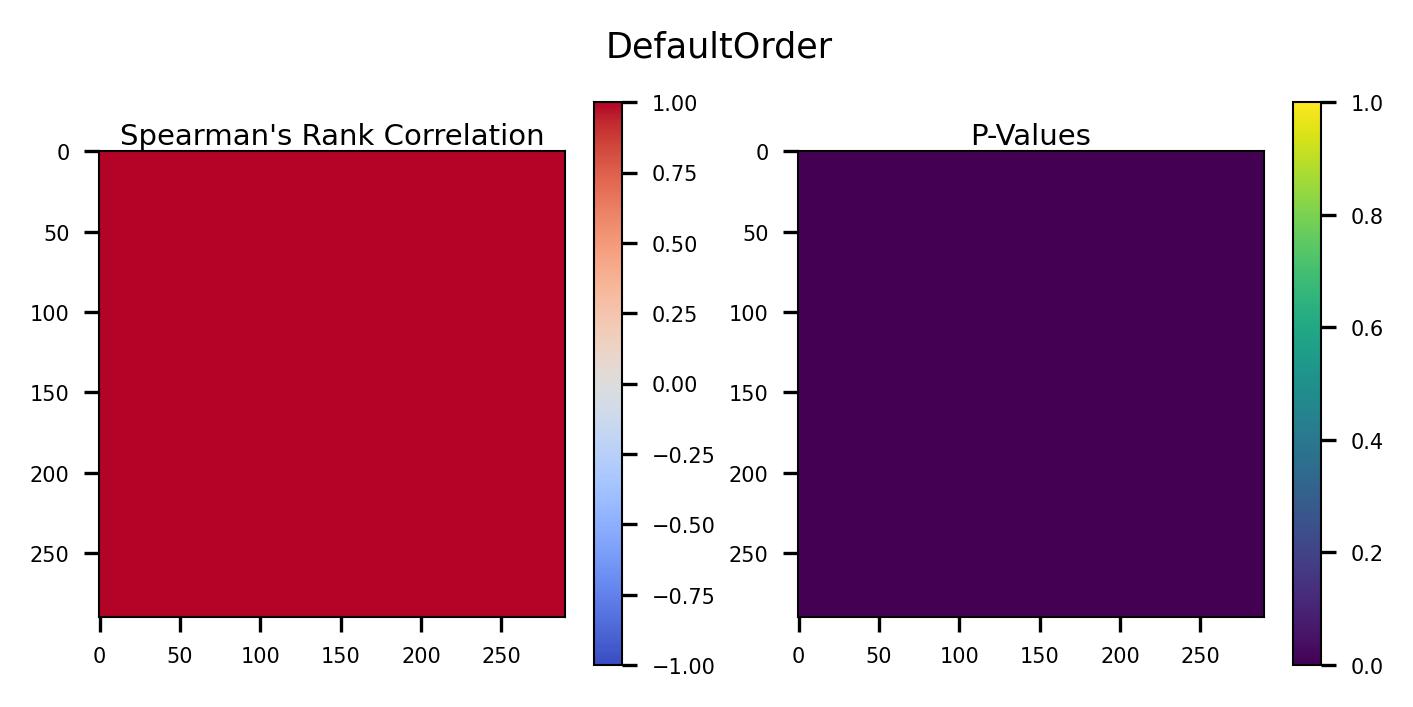

In [15]:
fig = showAdaptivity('DefaultOrder')

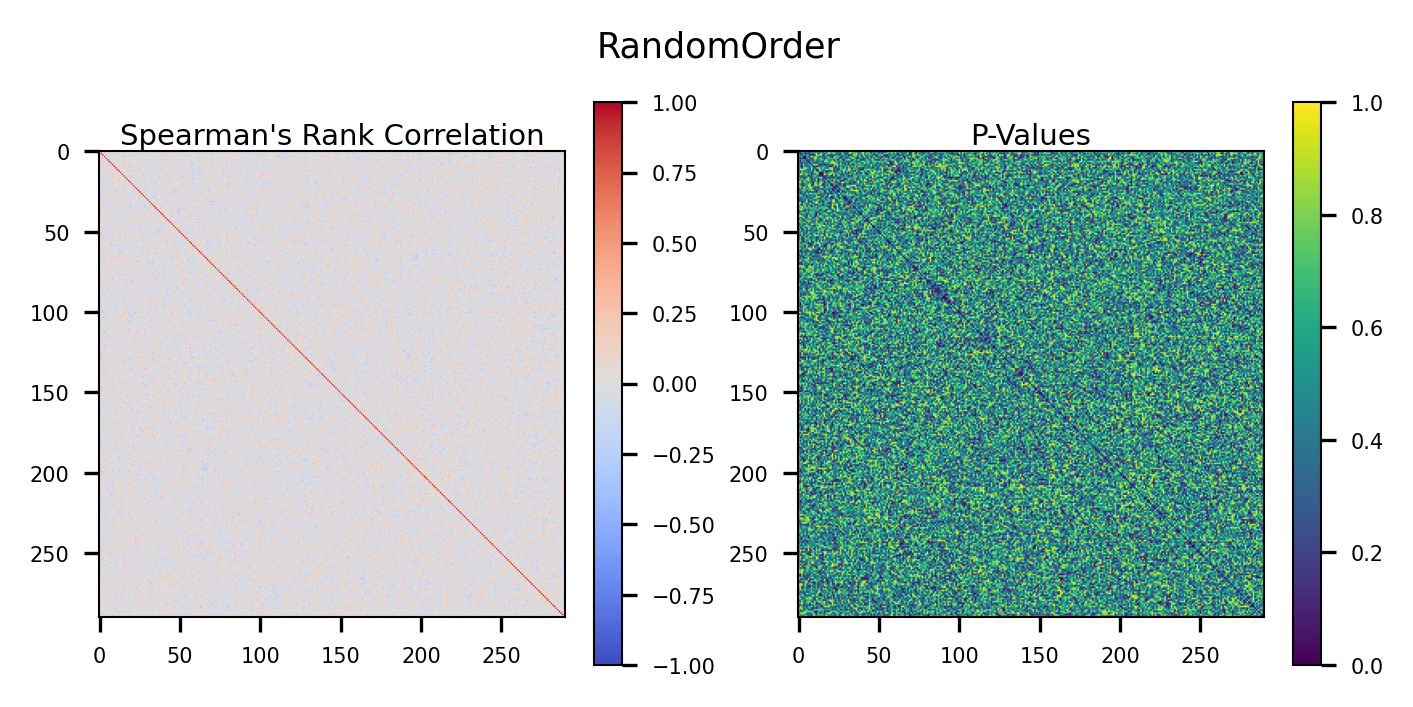

In [16]:
fig = showAdaptivity('RandomOrder')

### Adaptivity

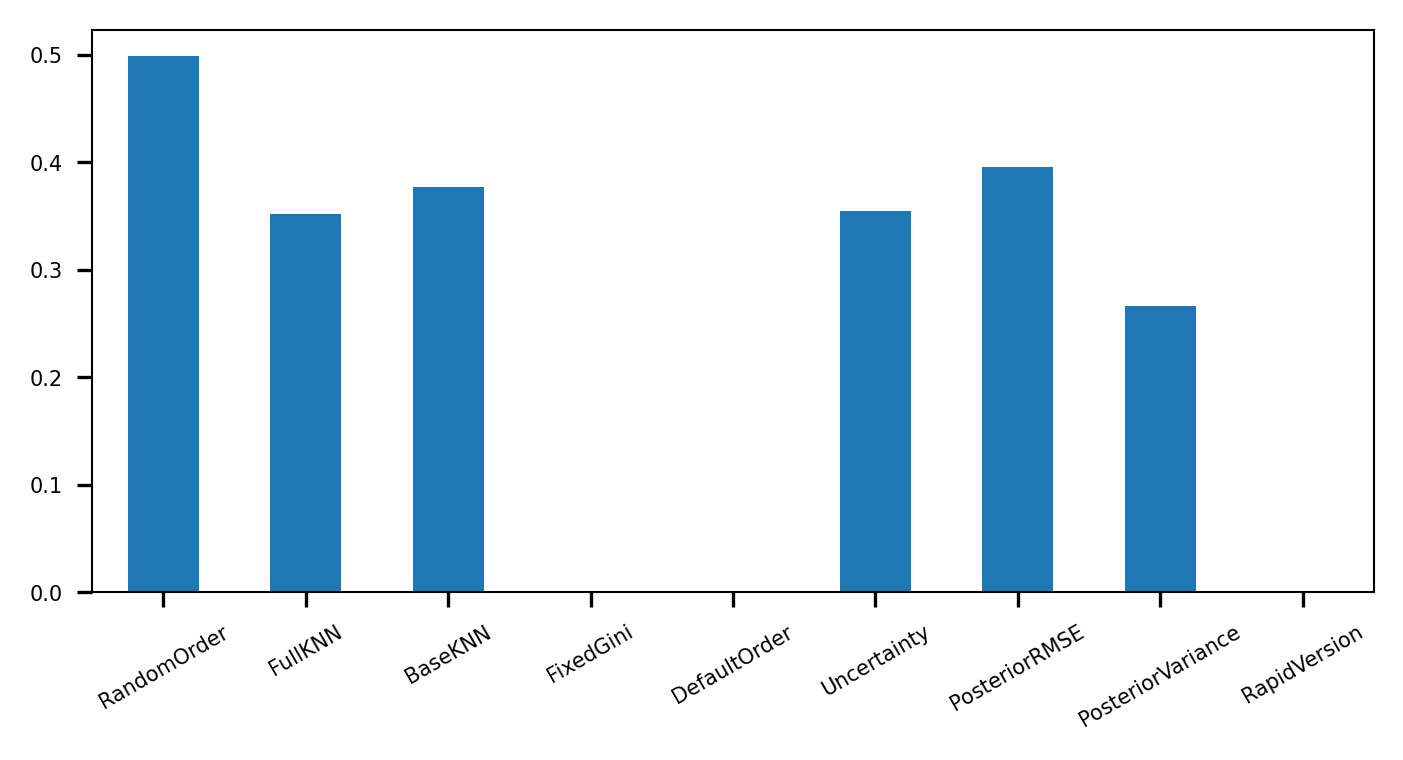

In [12]:
adaptivity = {}
for method in methods:
    R = spearmanr(ranks[method], axis=1)    
    adaptivity[method] = 0.5 - R.statistic.mean()/2
fig, ax = plt.subplots()
pd.Series(adaptivity).plot.bar(ax=ax, rot=30)
vis.savefig(fig, save_figures, 'ecml-paper', folder_name, data_name, name=f'AdaptivityBar')

## Similarity of Methods

In [6]:
M = len(ranks.values())
similarity_matrix = np.ones((M,M))
for i, method1 in enumerate(methods):
    N = ranks[method1].values.shape[1]
    for j, method2 in enumerate(methods[:i]):
        similarity = 1 - 6*np.square(ranks[method1] - ranks[method2]).sum(axis=1).mean()/(N**3-N)
        similarity_matrix[j,i] = similarity
        similarity_matrix[i,j] = similarity
similarity = pd.DataFrame(similarity_matrix, index=methods, columns=methods)

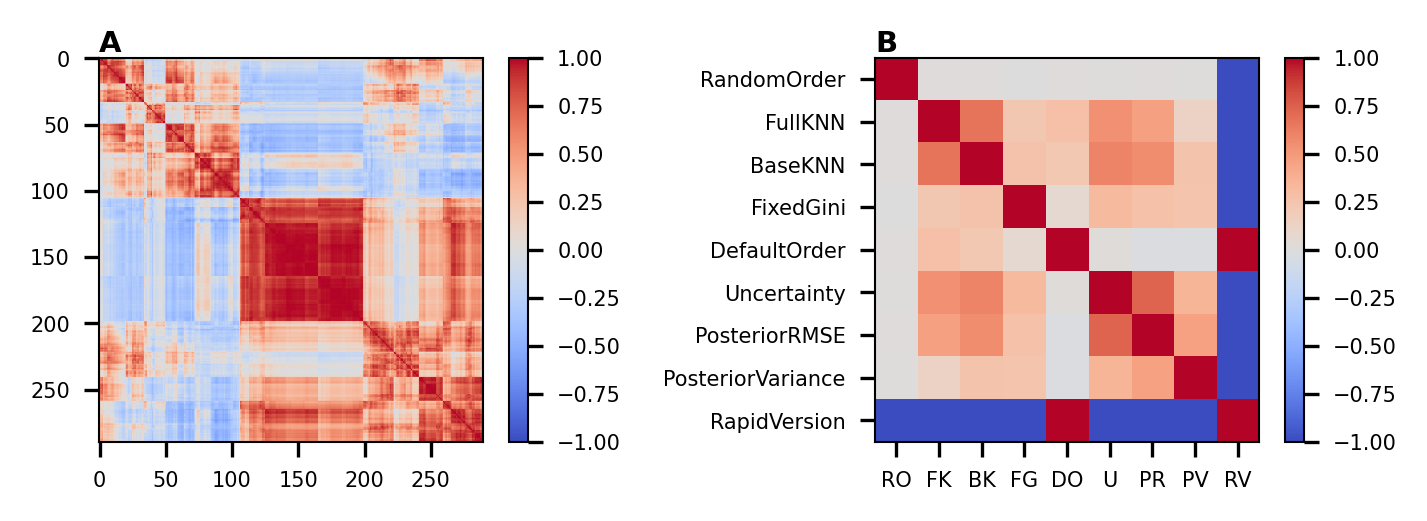

In [15]:
fig, (cor,ax) = plt.subplots(1,2, figsize=(vis.textwidth, 0.35*vis.textwidth))
h1 = ax.imshow(similarity, vmin=-1, vmax=1, cmap='coolwarm')
# Setting tick marks
ax.set_xticks(np.arange(len(similarity.columns)))
ax.set_yticks(np.arange(len(similarity.index)))
ax.set_xticklabels(similarity.index.to_series().apply(lambda x:''.join(filter(lambda x: not x.islower(), x))[:2]), ha='center')
ax.set_yticklabels(similarity.index)
fig.colorbar(h1, ax=ax)

R = spearmanr(ranks['PosteriorRMSE'], axis=1)   
D = R.statistic

linkage_matrix = linkage(D, 'ward')
# Obtain the order of rows and columns after clustering
# This part orders the matrix so that similar rows and columns are adjacent
row_order = leaves_list(linkage_matrix)
D = R.statistic[row_order, :][:, row_order]

h2 = cor.imshow(D, cmap='coolwarm', vmin=-1, vmax=1)
# cor.set_title("Spearman's Rank Correlation")
fig.colorbar(h2,ax=cor)
fig.text(-0,1, 'A', va='bottom', ha='left', weight='bold', transform=cor.transAxes)
fig.text(-0,1, 'B', va='bottom', ha='left', weight='bold', transform=ax.transAxes)

fig.tight_layout()
vis.savefig(fig, save_figures, 'ecml-paper', name='MethodCorrelation')

In [14]:
similarity.index.to_series().apply(lambda x:''.join(filter(lambda x: not x.islower(), x))[:2])

RandomOrder          RO
FullKNN              FK
BaseKNN              BK
FixedGini            FG
DefaultOrder         DO
Uncertainty           U
PosteriorRMSE        PR
PosteriorVariance    PV
RapidVersion         RV
dtype: object

Text(0.5, 0.98, 'PosteriorRMSE')

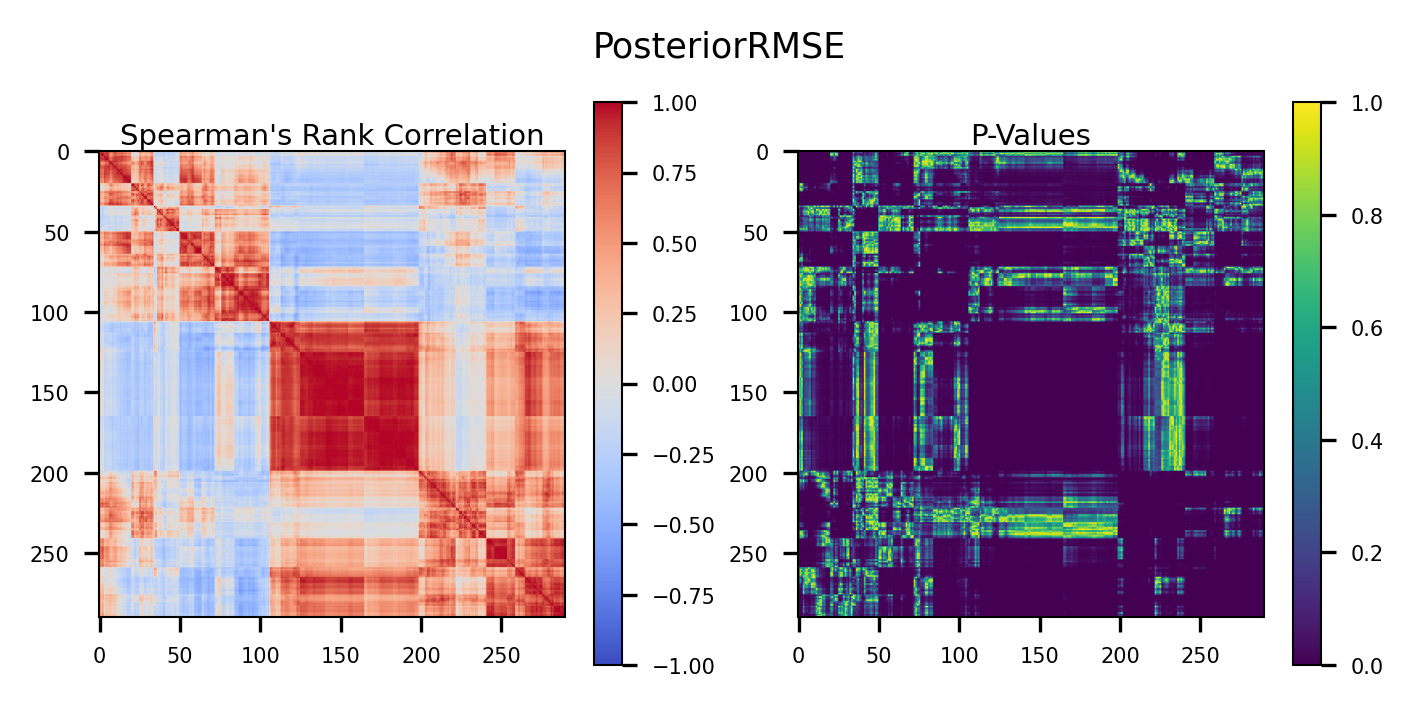

In [14]:

method = 'PosteriorRMSE'
fig, (ax1, ax2) = plt.subplots(1, 2)
R = spearmanr(ranks[method], axis=1)    

# Perform hierarchical clustering
# 'ward' is one of the methods you can use for linkage; it minimizes the variance of clusters being merged.
# For similarity matrix, you might want to experiment with 'single', 'complete', 'average', 'ward', etc.
linkage_matrix = linkage(R.statistic, 'ward')

# Obtain the order of rows and columns after clustering
# This part orders the matrix so that similar rows and columns are adjacent
row_order = leaves_list(linkage_matrix)
D = R.statistic[row_order, :][:, row_order]

h1 = ax1.imshow(R.statistic[row_order, :][:, row_order], cmap='coolwarm', vmin=-1, vmax=1)
ax1.set_title("Spearman's Rank Correlation")
plt.colorbar(h1)
h2 = ax2.imshow(R.pvalue[row_order, :][:, row_order], vmin=0, vmax=1)
ax2.set_title("P-Values")
plt.colorbar(h2)
fig.suptitle(method)
